In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import seaborn as sns
sns.set()

# Original data

In [2]:
raw_data = pd.read_csv('../data/Index2018.csv')

In [3]:
raw_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
raw_data.tail()

,date,spx,dax,ftse,nikkei
6264,23/01/2018,2839.130362,13559.60,7731.827774,24124.15
6265,24/01/2018,2837.544008,13414.74,7643.428966,23940.78
6266,25/01/2018,2839.253031,13298.36,7615.839954,23669.49
6267,26/01/2018,2872.867839,13340.17,7665.541292,23631.88
6268,29/01/2018,2853.528411,13324.48,7671.533300,23629.34


In [5]:
df_comp = raw_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.drop(['dax', 'ftse', 'nikkei'], axis=1, inplace=True)
df_comp.rename(columns={'spx': 'market_value'}, inplace=True)
df_comp.set_index('date', inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

In [6]:
df.tail()

,market_value
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


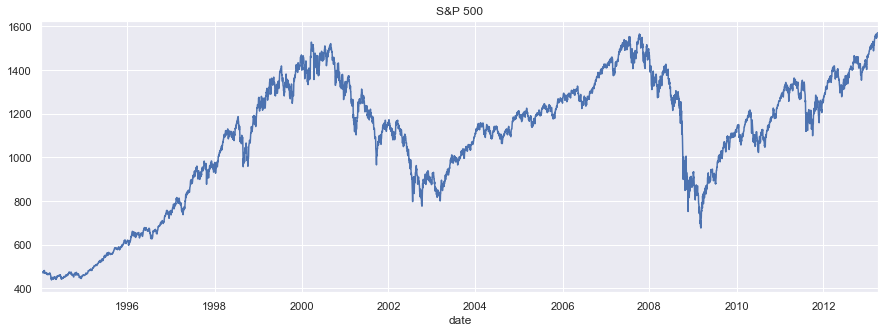

In [7]:
df.market_value.plot(figsize=(15, 5))
plt.title("S&P 500")
plt.show()

# White Noise

White noise is a series of random data that has no pattern. Because it has no pattern, we cannot predict the future. White noise has three conditions: 1) constant mean, 2) constant variation, and 3) no autocorrelation.

Let's create a white noise time-series data that has the same mean and std as the S&P closing price. If the data resembles white noise, we will not try to predict. 

In [8]:
# random value from normal distribution
wn = np.random.normal(df_comp.market_value.mean(), df_comp.market_value.std(), len(df)) 
df.loc[:, 'wn'] = wn

In [9]:
# means are similar but different because np.random.normal generates values individually
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1280.644519
std,292.559287,491.038027
min,438.920000,-521.599292
25%,914.620000,942.492406
50%,1144.650000,1282.865594
75%,1316.280729,1609.083363
max,1570.252238,2908.162921


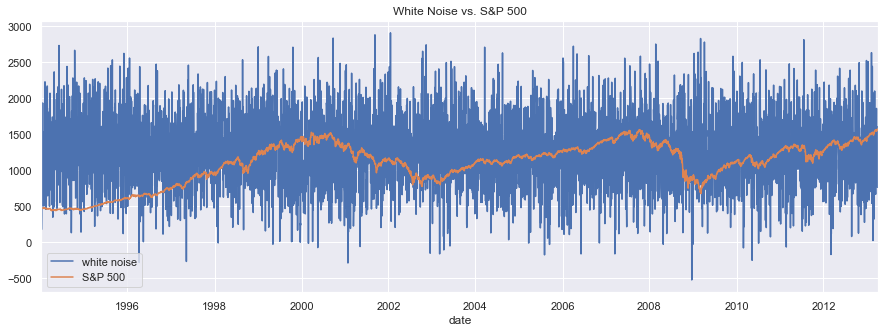

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
df.wn.plot()
df.market_value.plot()

plt.title("White Noise vs. S&P 500")
plt.legend(['white noise', 'S&P 500'])
plt.show()

It does not seem like the S&P 500 data resembles white noise.

# Random Walk

Random Walk is a type of time series where difference between two consecutive periods are simply white noise. 


$$
P_t = P_{t-1} + \epsilon_t
$$

where $P_t = \text{prices}$, 
$\epsilon_t = \text{residuals}$ which is white noise.
$$\epsilon_t \sim WN(\mu, \sigma^2)$$


In Random Walk, the best predictor of tomorrow is today's data and we cannot predict the further future with great accuracy. 

In [11]:
# pre-genenarted random walk data
rw = pd.read_csv('../data/RandWalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst=True)
rw.set_index('date', inplace=True)
rw = rw.asfreq('b')

In [12]:
df['rw'] = rw.price

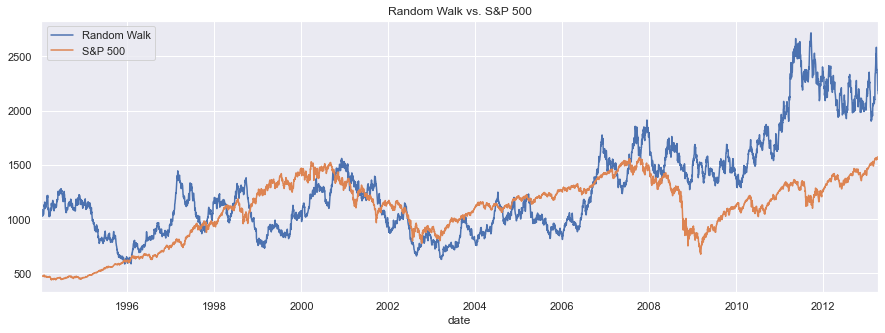

In [13]:
# plt.plot(rw)
fig, ax = plt.subplots(figsize=(15, 5))
df.rw.plot()
df.market_value.plot()

plt.title("Random Walk vs. S&P 500")
plt.legend(['Random Walk', 'S&P 500'])
plt.show()

S&P data looks much like random walk than white noise for the following reasons: 
- Small variation between consecutive time periods
- Both have cyclical increases and decreases in short periods of time 

# Stationarity (covariance stationary)

Covariance stationary or weak-form stationary means a type of timeseries data where any two same-sized consecutive samples of data have the same covariances. 

Covariance stationarity assumes.. 

* Constant mean 
* Constant variation 
* $\text{Cov}(x_n, x_{n+k}) = \text{Cov}(x_m, x_{m+k})$

White noise is an example of stationary data. 

The Dickey-Fuller test tests whether data comes from stationary process. Null hypothesis is that data is non-stationary, so 1 lag auto correlation coefficient is lower than 1. The alternative hypothesis is data is stationary. 
$$
H_0: \varphi_1 < 1 \\
H_1: \varphi_1 = 1
$$

We would want to test if data comes from stationarity process in order to pick the right model.

In [14]:
# augmented Dickie-Fuller test on market value
sts.adfuller(df.market_value)

(-1.7369847452352472,
 0.4121645696770604,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

The return values represent the following in order:
- adf : The test statistic.
- p-value : MacKinnon"s approximate p-value based on MacKinnon (1994, 2010).
- used lag : The number of lags used in regression when determining the test statistic.
- n-obs : The number of observations used for the ADF regression and calculation
    of the critical values.
- critical values : Critical values for the test statistic at the 1 %, 5 %, and 10 %
    levels. Based on MacKinnon (2010).
- icbest : The maximized information criterion if autolag is not None.
- resstore : A dummy class with results attached as attributes.


The test statistic (t statistic) is -1.73 and is greater than all critical values of all the significance levels. THerefore, there is not sufficient evidence to reject the null at any significant level. The p-value 0.41 also shows that we cannot reject the null, so the data is non-stationary. 

There is auto-correlation in 18 periods. We will take this into account when picking the right model. 

The number of observations used in the analysis is 4996. 4996 + 18 = 5014 ~ len(df.market_value).

Let's run the test again on the whiste noise data.

In [15]:
# white noise
sts.adfuller(df.wn)

(-37.025608997545504,
 0.0,
 3,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 75968.5971307579)

The p-value (0.0) shows there is significant evidence to reject the null, so the white noise data is stationary as expected.

In [16]:
# random walk
sts.adfuller(df.rw)

(-1.3286073927689719,
 0.6159849181617385,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

The p-value (0.64) shows there is no significant evidence to reject the null. There are 61.6% of chances that this is non-stationary. So the random walk data is not stationary. 

# Seasonality

Seasonality is certain trends will appear on a cyclical basis, like temperature in the year.
We can decompose data into three components;
* Trend = Pattern
* Seasonal = Cyclincal effects
* Residual = Error of prediction

There are two "Naive" decomposition methods;

* Additive 
  * observed = trend + seasonal + residual 
* Multiplicative 
  * observed = trend x seasonal x residual 

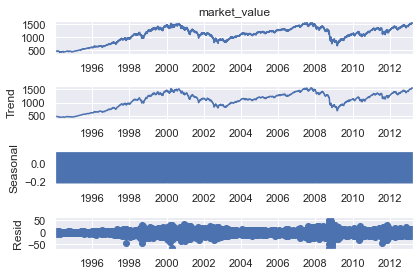

In [17]:
s_dec_additive = seasonal_decompose(df.market_value, model="additive")
s_dec_additive.plot()
plt.show()

The trend part explains the most of the variability. 
Seasonal graph looks like a retangle. It is because it is constantly switching from negative to positive, which means there is no concrete cyclical pattern found. Therefore, there is no seasonality in the data. 

# The Autocorrelation Function (ACF )

The ACF computes autocorrelation for however many lags we are interested in simultaneously 
$$\rho(x_t, x_{t-1}), \\
\rho(x_t, x_{t-2}), \\
\rho(x_t, x_{t-3}), \\
...
$$
It returns a correlation value for each lag.

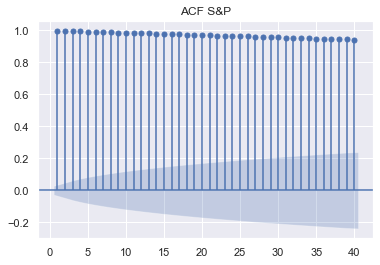

In [18]:
# market value 
sgt.plot_acf(df.market_value, lags=40, zero=False)  # zero=True will include the current value which is always 1
plt.title("ACF S&P")
plt.show()

The values on the x-axis represent lags. The numbers on the y-axis indicate the possible values for the auto correlation coefficient, which can be -1 to 1. The stem plot represents the correlation between the data and a lagged version of itself. 

The blue area represents the significance (confidence interval - autocorrelation value). The values situated outside the shade area are significantly different from zero, which suggests the existence of autocorrelation for that specific lag. The more the lag is, the wider the significance. This means the greater the distance in time, the more unlikely it is that this autocorrelation persists.

The high autocorrelation afer 30 lags indicates that the price even in a month back still serve as descent estimates.

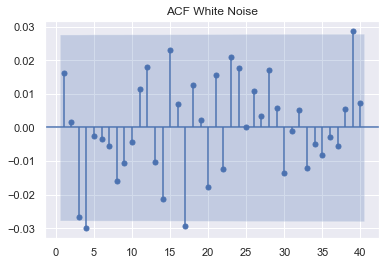

In [19]:
# white noise 
sgt.plot_acf(df.wn, lags=40, zero=False)
plt.title("ACF White Noise")
plt.show()

White noise has very small autocorrelation and the majority of them are within the significance level. This means the autocorrelation values are not significantly different from 0 and there is no auto correlation.

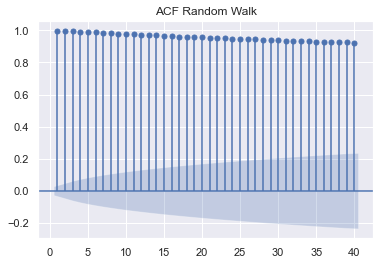

In [20]:
# random walk 
sgt.plot_acf(df.rw, lags=40, zero=False)
plt.title("ACF Random Walk")
plt.show()

Random walk shows a similar pattern as the market value. This means the market price is likely to be a type of random walk data.

# The Partial Autocorrelation Function (PACF)
* The ACF has second hand effect; e.g. $x_{t-3}$ affects $x_{t-2}$ and $x_{t-1}$, which in turn affect the present value. PACF removes the the indirect effect and calculates the direct effect of $x_{t-3}$ on $x_t$. 
* The ACF measures the accumulated effects past lags have on the current vaule, while the PACF measures the direct effect. 

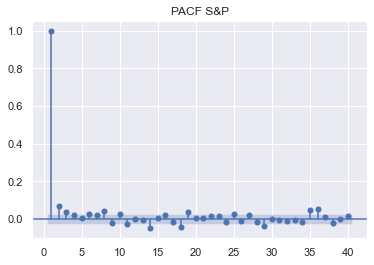

In [21]:
sgt.plot_pacf(df.market_value, lags=40, zero=False, method=('ols'))
plt.title("PACF S&P")
plt.show()

This suggests that there is no significant lag that directly affects the current value other than the first few lags. This contrasts ACF which had high autocorrelation up until 40 lags. The first lag autocorrelation should be the same as the ACF result as there is no other channel to cancel out in PACF.

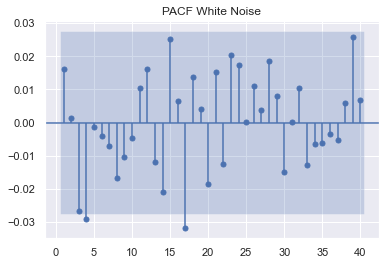

In [22]:
sgt.plot_pacf(df.wn, lags=40, zero=False, method=('ols'))
plt.title("PACF White Noise")
plt.show()

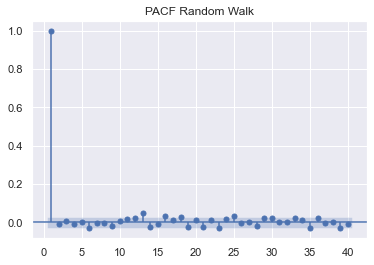

In [23]:
sgt.plot_pacf(df.rw, lags=40, zero=False, method=('ols'))
plt.title("PACF Random Walk")
plt.show()